# Recurrent Neural Network Model for EUR/USD Price Prediction
## Introduction
The aim of this study is to develop a recurrent neural network (RNN) model using the hourly closing price data of the Euro-USD currency pair over the past 12–13 days. The model’s predictions for the next time step are iteratively appended to the dataset, enabling the generation of 12-hour forward forecasts. This approach is employed to analyze the model’s performance in short-term exchange rate forecasting and to assess the effectiveness of recurrent networks on time series data.

## Data Preprocessing

In [1]:
!pip install tradermade     # Installs the TraderMade API library
import pandas as pd     # For data manipulation and analysis
import numpy as np     # For numerical operations and arrays
import tradermade as tm     # To fetch financial data from the TraderMade API
import matplotlib.pyplot as plt     # For plotting and visualization
from sklearn.preprocessing import MinMaxScaler     # For scaling and normalizing data
import os     # For file and directory operations
import random     # To generate random numbers and selections
import tensorflow as tf     # To build deep learning models
from tensorflow.keras.models import Sequential     # To define models as a sequence of layers
from tensorflow.keras.callbacks import ModelCheckpoint     # To save the best model during training
from tensorflow.keras.optimizers import Adam     # Adam optimizer for model training
from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsolutePercentageError     # Model evaluation metrics (RMSE, MAPE)
from tensorflow.keras.losses import MeanSquaredError     # Mean Squared Error as the loss function
from tensorflow.keras.layers import *     # To import all layer types
from tensorflow.keras.models import load_model     # To load a previously trained model

In [2]:
tm.set_rest_api_key("-J95ZeapONnhR_h8Oc7g")
# Sets the TraderMade API key
df = tm.timeseries(currency='EURUSD', start="2025-02-05-01:00",end="2025-02-21-08:00",interval="hourly",fields=["open", "high", "low","close"])
# Fetches hourly 'open', 'high', 'low', 'close' data for the EUR/USD currency pair between 2025-02-05 01:00 and 2025-02-21 08:00
print(df.head())

                  date     open     high      low    close
0  2025-02-05 01:00:00  1.03785  1.03868  1.03724  1.03735
1  2025-02-05 02:00:00  1.03735  1.03855  1.03729  1.03848
2  2025-02-05 03:00:00  1.03846  1.03863  1.03792  1.03795
3  2025-02-05 04:00:00  1.03797  1.03826  1.03760  1.03789
4  2025-02-05 05:00:00  1.03788  1.03790  1.03733  1.03778


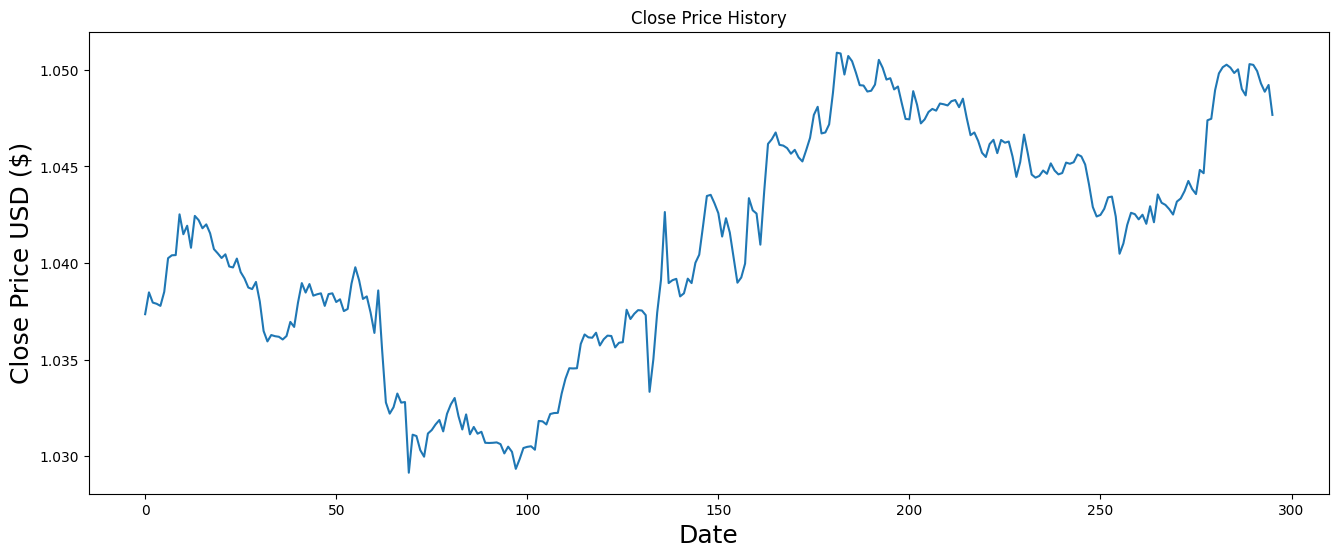

In [5]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Up to this point, the required libraries and API key have been successfully set up, data for the Euro/USD currency pair has been retrieved via the API, and the closing prices within the dataset have been visualized.

In [36]:
close = df.filter(['close'])
# Selects the 'close' (closing price) column

dataset = close.values
# Converts the data to a NumPy array

training_data_len = int(np.ceil(len(dataset) * .90))
# Sets aside 90% of the data as training data

scaler = MinMaxScaler(feature_range=(0,1))
# Creates a scaler to normalize the data between 0 and 1

scaled_data = scaler.fit_transform(dataset)
# Scales the data

time_step = 12
# Sets the input sequence length to 12 time steps

train_data = scaled_data[0:int(training_data_len), :]
# Extracts the training portion of the data

x_train = []
y_train = []

for i in range(time_step, len(train_data)):
    x_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])
    # Builds each 12-step input window (x) and its corresponding output (y)

    if i <= 13:
        print(x_train)
        print(y_train)
        # Prints the first few examples to the console (for checking)

[array([0.37747126, 0.42942529, 0.40505747, 0.40229885, 0.39724138,
       0.4308046 , 0.5108046 , 0.51770115, 0.51816092, 0.61517241,
       0.56781609, 0.58804598])]
[np.float64(0.5356321839080493)]
[array([0.37747126, 0.42942529, 0.40505747, 0.40229885, 0.39724138,
       0.4308046 , 0.5108046 , 0.51770115, 0.51816092, 0.61517241,
       0.56781609, 0.58804598]), array([0.42942529, 0.40505747, 0.40229885, 0.39724138, 0.4308046 ,
       0.5108046 , 0.51770115, 0.51816092, 0.61517241, 0.56781609,
       0.58804598, 0.53563218])]
[np.float64(0.5356321839080493), np.float64(0.6114942528735625)]


In [37]:
x_train, y_train = np.array(x_train), np.array(y_train)
# Converts training input and output lists into NumPy arrays

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Reshapes training data to (samples, time steps, features)

test_data = scaled_data[training_data_len - time_step:, :]
# Selects test data starting slightly before the training end to complete the window

x_test = []
y_test = dataset[training_data_len:, :]
# Initializes test inputs; test outputs are taken from the original (unscaled) dataset

for i in range(time_step, len(test_data)):
    x_test.append(test_data[i-time_step:i, 0])
    # Builds each 12-step window for the test data

x_test = np.array(x_test)
# Converts test inputs into a NumPy array

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# Reshapes test data to (samples, time steps, features)

At this stage of the process, the work has involved selecting only the 'close' (closing price) column from the dataset and converting it into a NumPy array for analysis. Subsequently, 90% of the data was allocated for training, with the remainder reserved for testing. To enable effective model learning, both the training and test datasets were scaled into the 0 to 1 range using MinMaxScaler. Input sequences were then structured into sliding windows, each consisting of 12 time steps, and these sequences were reshaped into 3D tensors to match the expected input format for models like RNN or LSTM. When preparing the test data, the process began slightly before the end of the training set to maintain complete window structures. Finally, the first few windows and target values were printed to the console for sampling and verification purposes.

## Model Architecture

In [17]:
SEED = 2018
# Sets the seed value to reduce randomness effects

os.environ['PYTHONHASHSEED'] = str(SEED)
# Sets the Python hash seed (for full determinism)

random.seed(SEED)
# Sets the Python random seed

np.random.seed(SEED)
# Sets the NumPy random seed

tf.random.set_seed(SEED)
# Sets the TensorFlow random seed

checkpoint = ModelCheckpoint(
    filepath='model_best.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
)
# Defines a checkpoint to save the best model based on the lowest loss

model = Sequential()
# Initializes a Sequential model

model.add(SimpleRNN(16, input_shape=(x_train.shape[1], 1), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)))
# Adds a SimpleRNN layer with 16 units, weights initialized using the specified seed

model.add(Dense(1))
# Adds a Dense layer with 1 neuron for output

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# Compiles the model using Adam optimizer and mean squared error (MSE) loss

history = model.fit(x_train, y_train, batch_size=1, epochs=300, callbacks=[checkpoint])
# Trains the model with batch size = 1 over 300 epochs, records training history

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


233/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343
Epoch 1: loss improved from inf to 0.01835, saving model to model_best.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0329
Epoch 2/300
234/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105
Epoch 2: loss improved from 0.01835 to 0.00826, saving model to model_best.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103
Epoch 3/300
253/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 3: loss improved from 0.00826 to 0.00582, saving model to model_best.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070
Epoch 4/300
240/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 4: loss improved from 0.00582 to 0.00459, saving model to model_best.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054
Epoch 5/300
239/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 5: loss improved from 0.00459 to 0.00389, saving model to model_best.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

In [18]:
best_model = tf.keras.models.load_model('model_best.keras')
# Loads the best model saved during training

predictions = best_model.predict(x_test)
# Makes predictions on the test data

predictions = scaler.inverse_transform(predictions)
# Transforms the predictions back to the original price scale

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
# Calculates the root mean squared error (RMSE) between the predictions and actual values

rmse
# Prints the RMSE value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


np.float64(0.0008243834046896665)

In this section, a fixed seed value was set to reduce the influence of randomness on the model’s results, ensuring reproducibility across training runs. A checkpoint mechanism was defined to automatically save the version of the model with the lowest loss during training.

Since determining the optimal number of neurons in the layer relies on a trial-and-error approach, using a fixed seed allowed for a fair and consistent comparison between models with different neuron counts. This approach ensured that all models began training from the same initial weights, eliminating variability due to random initialization and isolating the effect of the neuron configuration itself.

Experimental results showed that the lowest mean squared error (MSE) was achieved with a single-layer SimpleRNN model containing 16 neurons. This model was compiled using the Adam optimization algorithm and mean squared error (MSE) loss function, then trained over 300 epochs. After training, the best-performing model was loaded, predictions were generated on the test data, and these predictions were transformed back to the original scale. Finally, the root mean squared error (RMSE) was calculated to assess the prediction accuracy.

<ipython-input-19-29c328925233>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


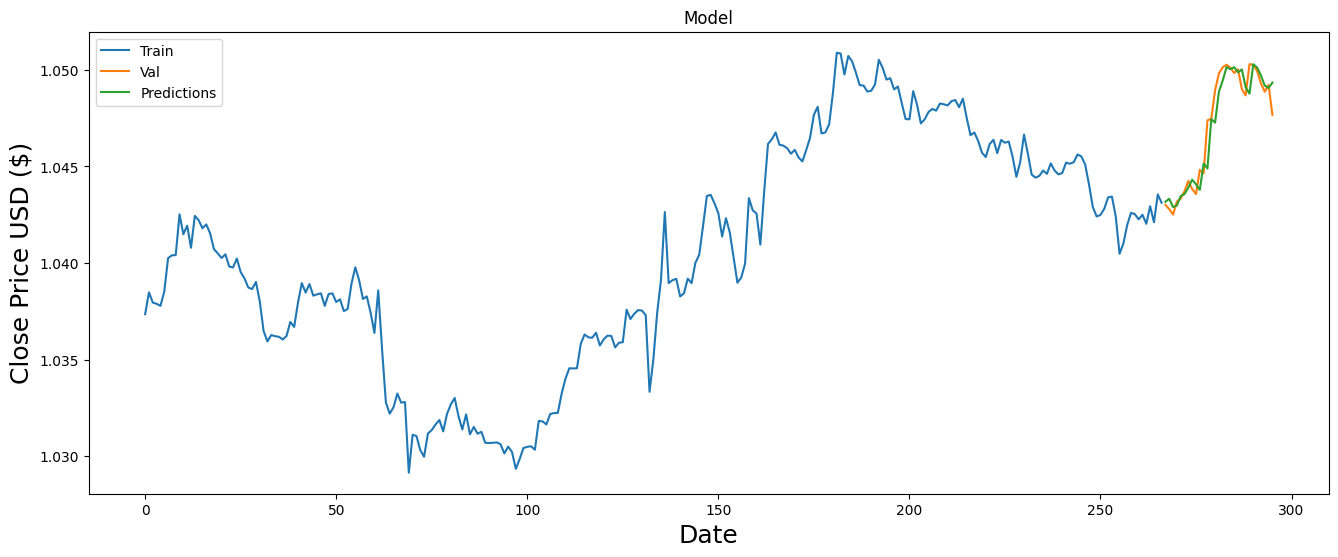

In [19]:
train = close[:training_data_len]
valid = close[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()

##  Iterative Use of the Model and Multi-Step Forecasting

In [38]:
last_tm_hours = scaled_data[-time_step:, :]
# Takes the last 'time_step' portion of the scaled data (last input window for the model)

last_tm_hours = np.array(last_tm_hours)
# Converts the slice to a NumPy array

last_tm_hours = np.reshape(last_tm_hours, (1, last_tm_hours.shape[0], 1))
# Reshapes input to a 3D tensor (samples, time steps, features)

forecasts = []
# Initializes an empty list to store forecasts

for i in range(time_step):
    prediction = best_model.predict(last_tm_hours)
    # Gets the next time step prediction from the model

    forecasts.append(prediction)
    # Appends the prediction to the forecasts list

    last_tm_hours = np.delete(last_tm_hours, 0)
    # Removes the oldest (first) value from the input window

    last_tm_hours = np.append(last_tm_hours, prediction)
    # Appends the new prediction to the end of the input window

    last_tm_hours = np.reshape(last_tm_hours, (1, last_tm_hours.shape[0], 1))
    # Reshapes the updated window back into a 3D tensor

    print(last_tm_hours)
    # Prints the updated input window at each step to the console

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[[0.95172414]
  [0.96045977]
  [0.91356322]
  [0.8983908 ]
  [0.97287356]
  [0.97103448]
  [0.95632184]
  [0.92689655]
  [0.90712644]
  [0.92321839]
  [0.85195402]
  [0.86037403]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[[0.96045977]
  [0.91356322]
  [0.8983908 ]
  [0.97287356]
  [0.97103448]
  [0.95632184]
  [0.92689655]
  [0.90712644]
  [0.92321839]
  [0.85195402]
  [0.86037403]
  [0.86914444]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[[0.91356322]
  [0.8983908 ]
  [0.97287356]
  [0.97103448]
  [0.95632184]
  [0.92689655]
  [0.90712644]
  [0.92321839]
  [0.85195402]
  [0.86037403]
  [0.86914444]
  [0.87441134]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[[0.8983908 ]
  [0.97287356]
  [0.97103448]
  [0.95632184]
  [0.92689655]
  [0.90712644]
  [0.92321839]
  [0.85195402]
  [0.86037403]
  [0.86914444]
  [0.87441134]
  [0.88308239]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[[0.97287356]
  [0.97103448]
  [0.95632184]
  [0.92689655]
  [0.90712644]
  [0.92

In [39]:
forecasts = np.array(forecasts)
# Converts the forecasts list to a NumPy array

forecasts = np.reshape(forecasts, (time_step, 1))
# Reshapes the forecasts array to (time_step, 1)

forecasts = scaler.inverse_transform(forecasts)
# Applies inverse scaling to return forecasts to original price values

dataset_indices = np.arange(len(dataset) - time_step)
# Creates index range for the historical predictions within the dataset

forecasts_indices = np.arange(len(dataset) - time_step, len(dataset) + len(forecasts) - time_step + 1)
# Creates index range for the forward-looking forecasts

all_data = []
# Initializes a list to store all past data input windows

for i in range(time_step, len(scaled_data)):
    all_data.append(scaled_data[i - time_step:i, 0])
    # Builds each 12-step input window and appends it to the list

all_data = np.array(all_data)
# Converts the list to a NumPy array

all_data = np.reshape(all_data, (all_data.shape[0], all_data.shape[1], 1))
# Reshapes array to (samples, time steps, features) as required by the model

all_data_prediction = best_model.predict(all_data)
# Makes predictions on all past input windows using the model

all_data_prediction = scaler.inverse_transform(all_data_prediction)
# Applies inverse scaling to return historical predictions to original price values

forecasts = np.append(all_data_prediction[-1], forecasts)
# Appends the last historical prediction to the start of the forward forecasts

forecasts = np.reshape(forecasts, (time_step + 1, 1))
# Reshapes the combined forecast array to (time_step + 1, 1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


At this stage, forward forecasts were generated using the model, starting from the last `time_step` segment of the existing dataset. Each new prediction was iteratively appended to the input sequence to build a chain of successive time step forecasts. Once the forward predictions were complete, the model was also applied to all historical input windows to obtain predictions across the full dataset. These historical predictions were then combined with the forward forecasts to create a complete prediction sequence. Finally, all predictions were inverse transformed back to the original price scale. This process provides a unified structure for visualizing and analyzing both past and future predictions.

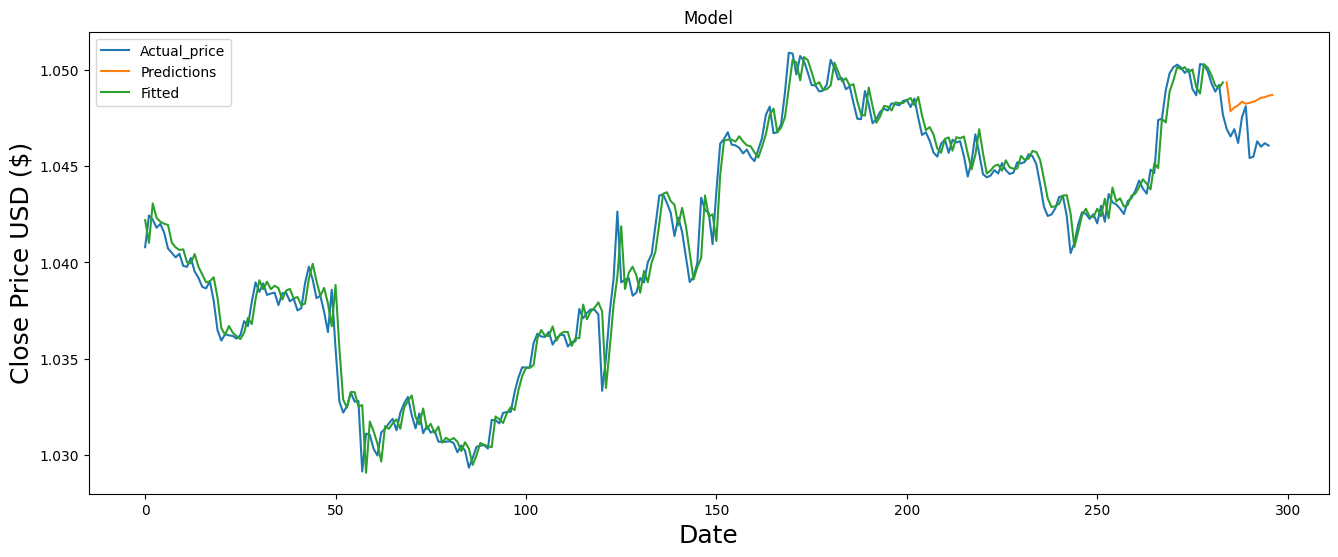

In [40]:
df_2 = tm.timeseries(currency='EURUSD', start="2025-02-21-09:00", end="2025-02-21-20:00", interval="hourly", fields=["close"])
# Fetches hourly 'close' price data from 2025-02-21 09:00 to 20:00 using the API

next_12_hour = df_2["close"].values
# Converts the fetched 'close' price column into a NumPy array

dataset = np.append(dataset, next_12_hour)
# Appends the new price data to the end of the existing dataset

dataset_indices = np.arange(len(dataset) - time_step)
# Creates a new index range for the updated dataset

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(dataset_indices,dataset[time_step:])
plt.plot(forecasts_indices,forecasts)
plt.plot(all_data_prediction)
plt.legend(['Actual_price', 'Predictions', 'Fitted'], loc='upper left')
plt.show()

## Conclusion
In this study, a SimpleRNN model was developed and applied to forecast the hourly closing prices of the Euro/USD currency pair. The model was trained using historical price data, and an iterative forecasting process was designed to generate forward-looking predictions. Model performance was evaluated using the root mean squared error (RMSE) metric, with the best results obtained from a single-layer architecture containing 16 neurons. To minimize the influence of randomness on model outcomes and ensure fair comparability across different architectures, a fixed seed value was employed.

While the results on the test set generally appear to align with the actual values, it was observed that the model tends to converge towards the most recent actual value rather than effectively capturing broader market dynamics. Consequently, when the predicted values are iteratively fed back into the model for multi-step forecasting, subsequent predictions progressively converge towards the initial forecast value. Although the final set of 12-hour predictions can provide an indication of the general trend direction, the model lacks the ability to reliably detect trend reversals or significant directional shifts. Future work could focus on expanding the model architecture, incorporating additional features such as volume, momentum, or technical indicators, and conducting comparative analyses with other deep learning architectures to enhance predictive robustness.